## Analysis with ML

## 6. Cluster Analysis with Agglomerative Clustering (Doesnt work well)

We'll group instruments based on their statistical properties (e.g., correlation clusters) to identify similar trading behaviors using the Agglomerative Clustering algorithm, which might handle the data distribution better than K-means (tested and didn't work well..).


## 7. Cluster Analysis with Gaussian Mixture Model (GMM) (Doesn't work well)

We'll group instruments based on their statistical properties (e.g., correlation clusters) to identify similar trading behaviors using the Gaussian Mixture Model (GMM) algorithm, which might handle the data distribution better than K-means or Agglomerative Clustering.


## Issues with K-Means analysis
- Assumes clusters are spherical and evenly sized.
- Requires pre-specifying the number of clusters.
- Sensitive to initial centroid placement and can converge to local minima.
- Not effective for clusters of varying sizes and densities.

In [2]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 6. Cluster Analysis with Hierarchical Clustering (15 clusters)

We'll group instruments based on their statistical properties (e.g., correlation clusters) to identify similar trading behaviors using hierarchical clustering with a suitable distance metric.

Hierarchical clustering with a suitable distance metric can handle low correlation values better and provide more meaningful clusters. (as we saw in the corr matrix above)

/var/folders/bh/9d882fls0ln_dby8ycw97nrc0000gr/T/ipykernel_36580/1245295946.py:18: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(distance_matrix, method='ward')


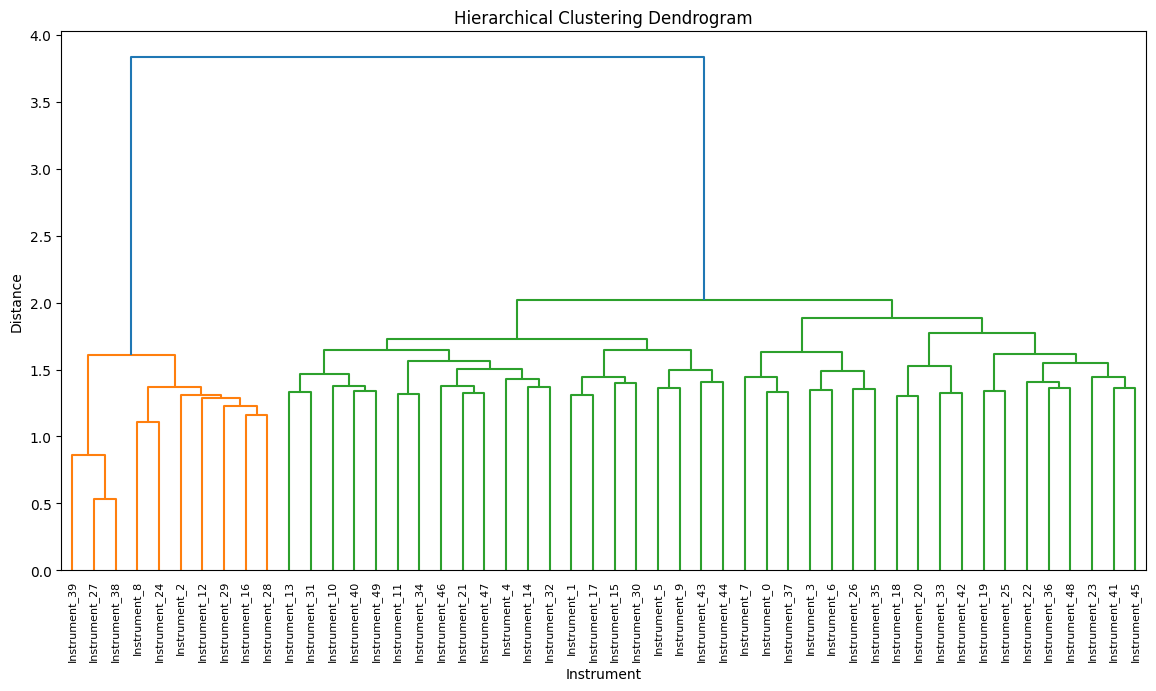

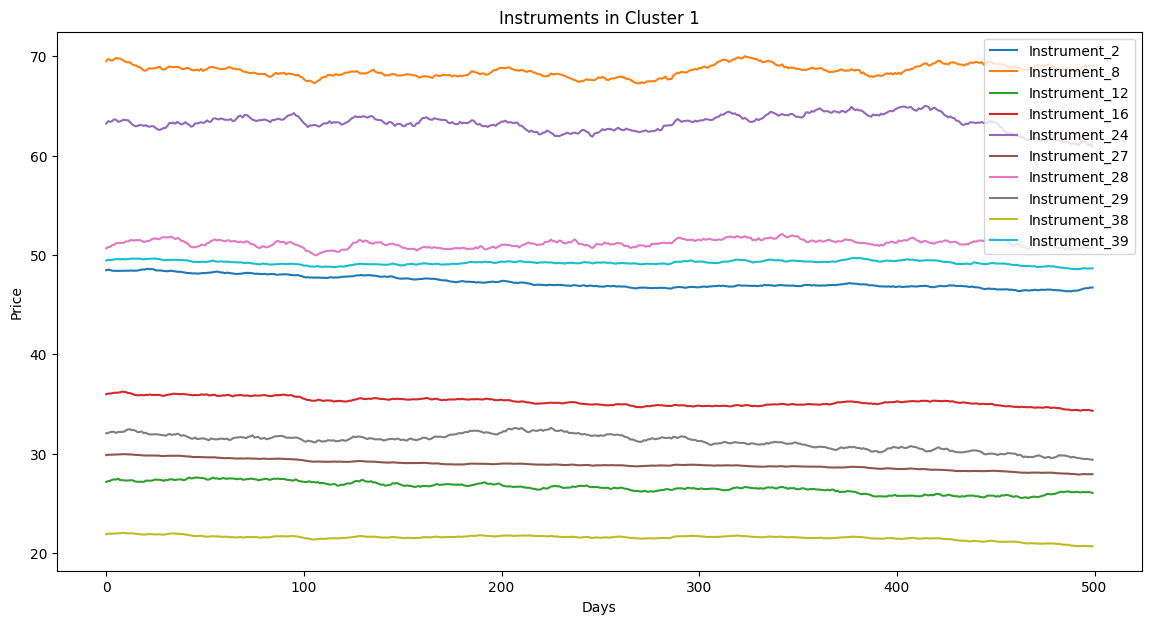

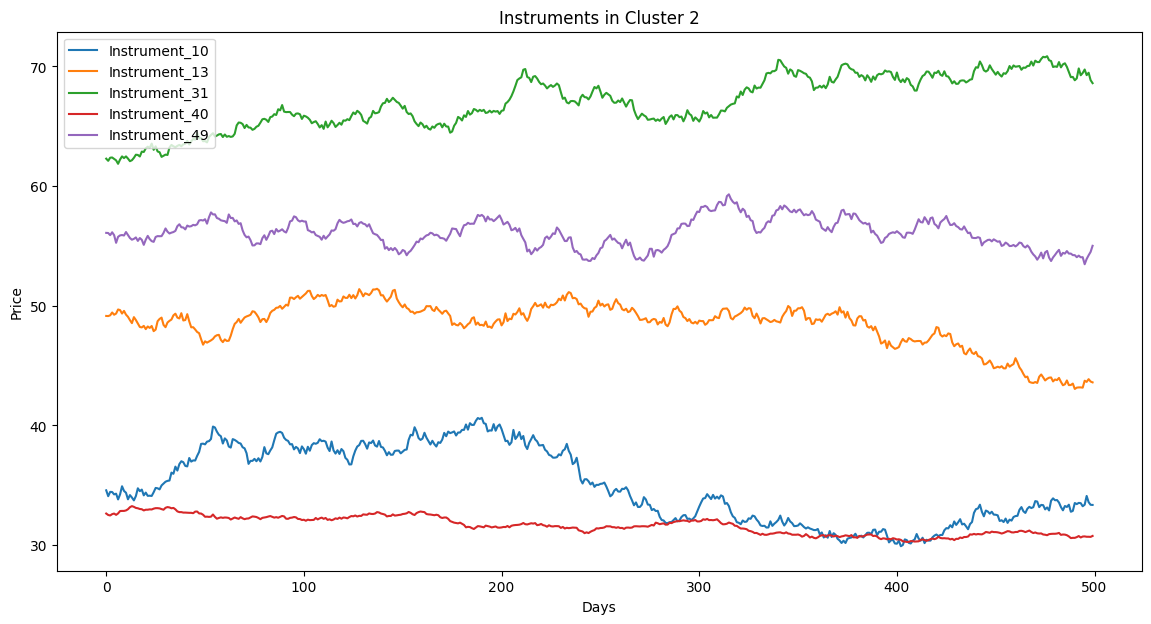

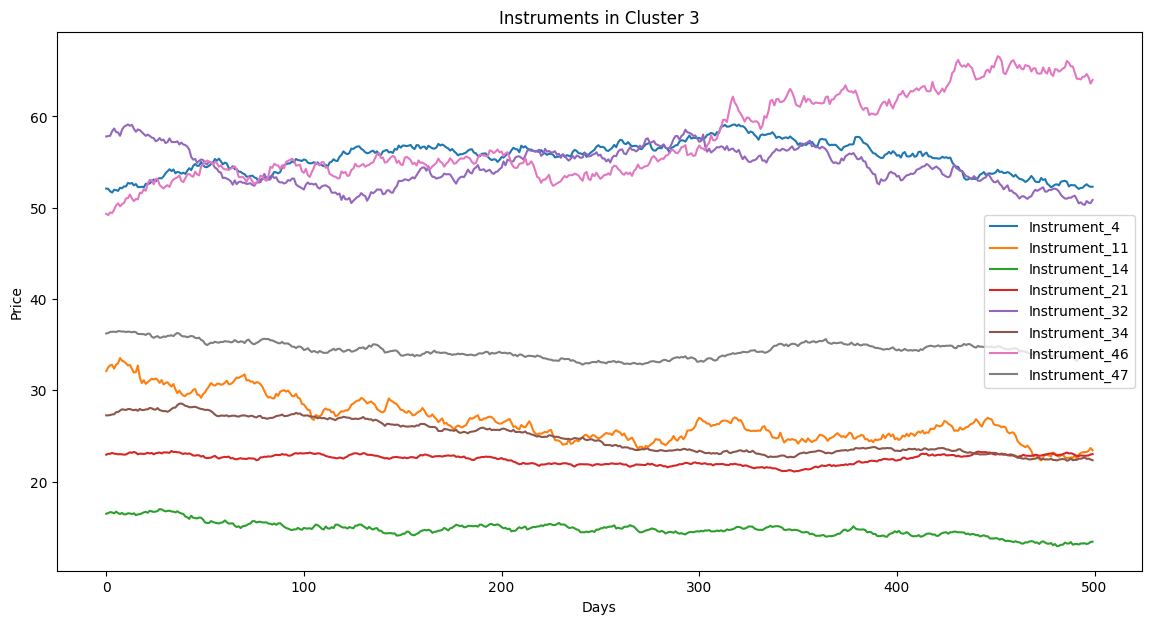

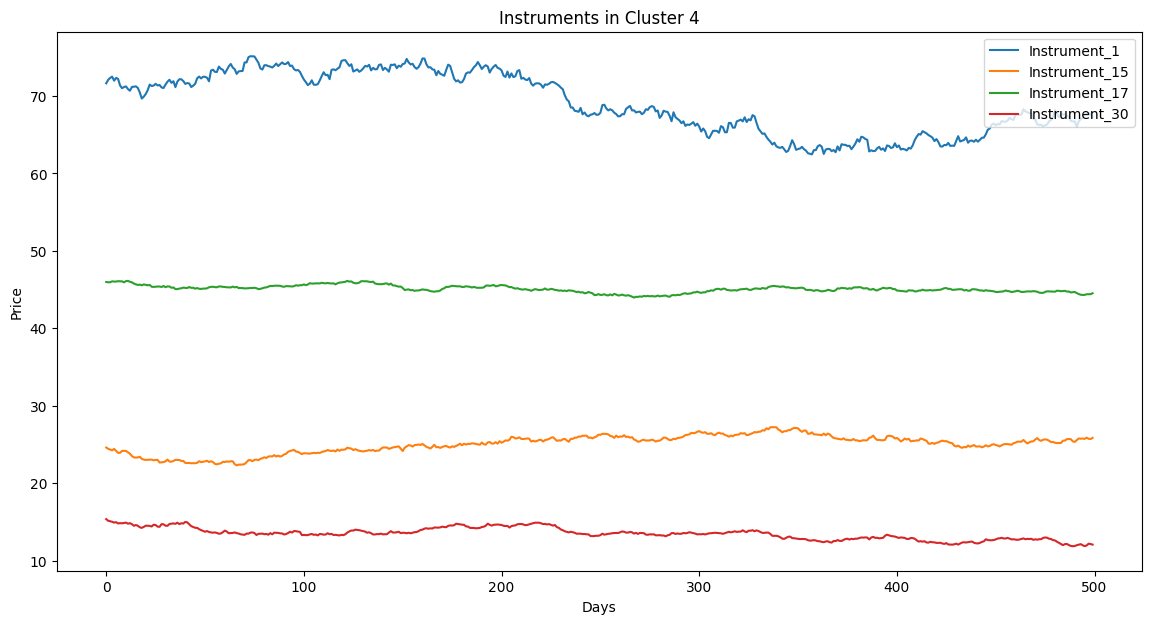

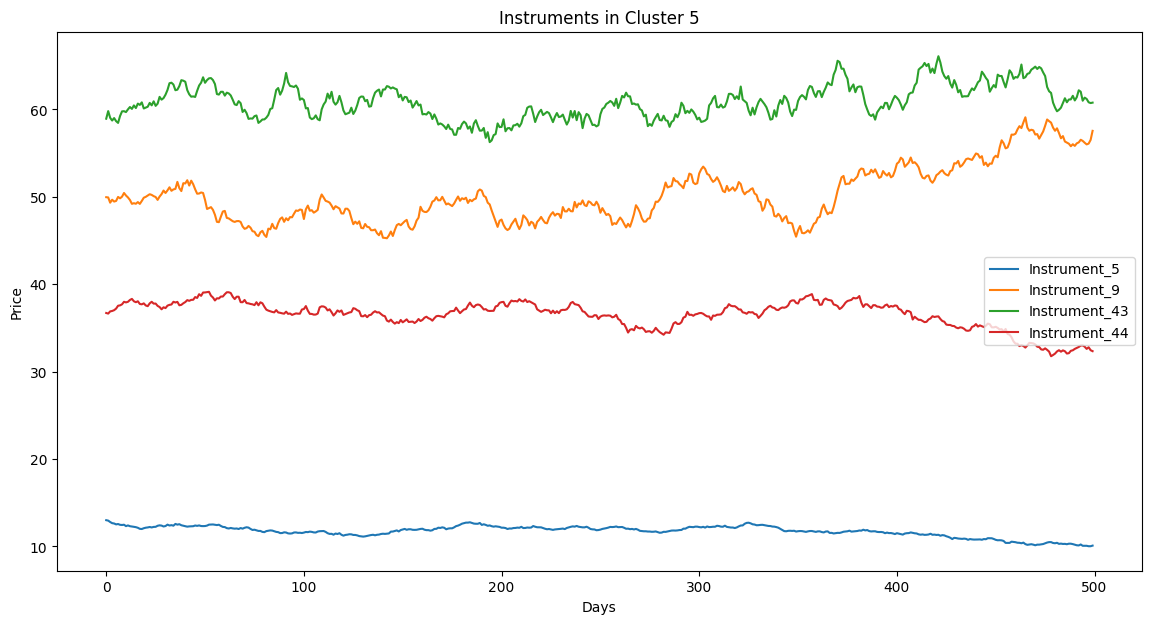

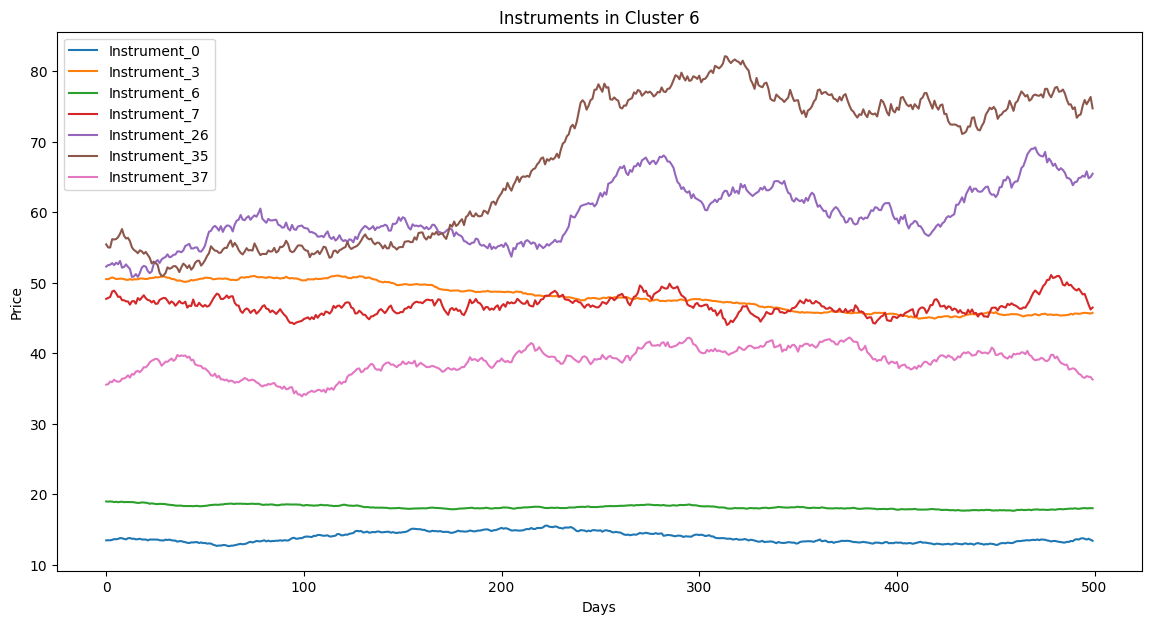

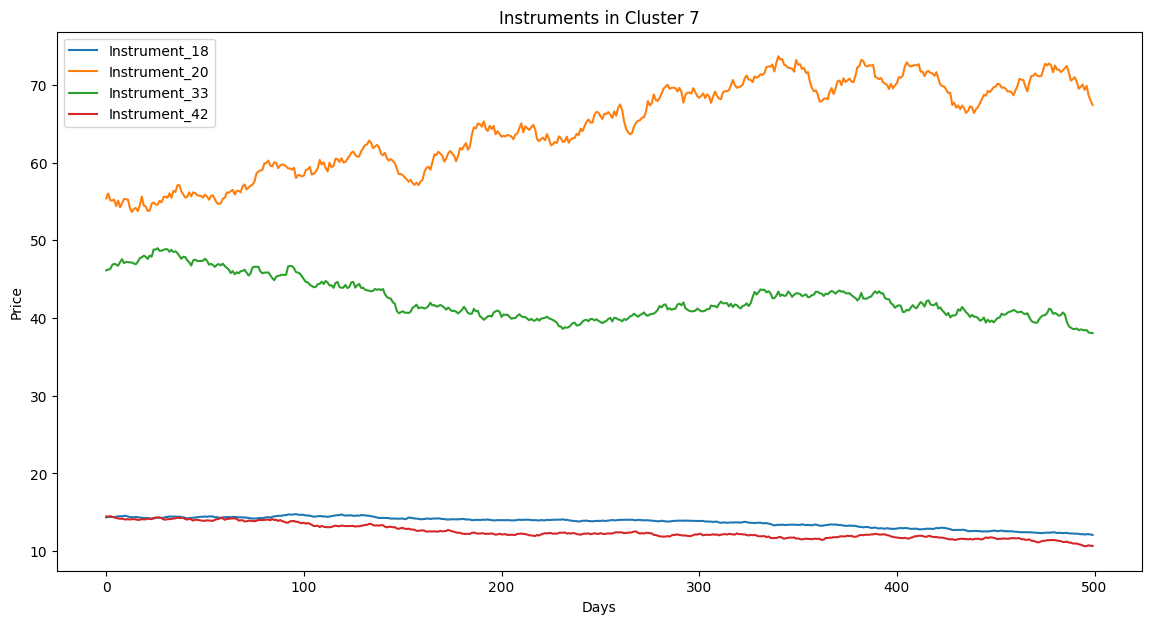

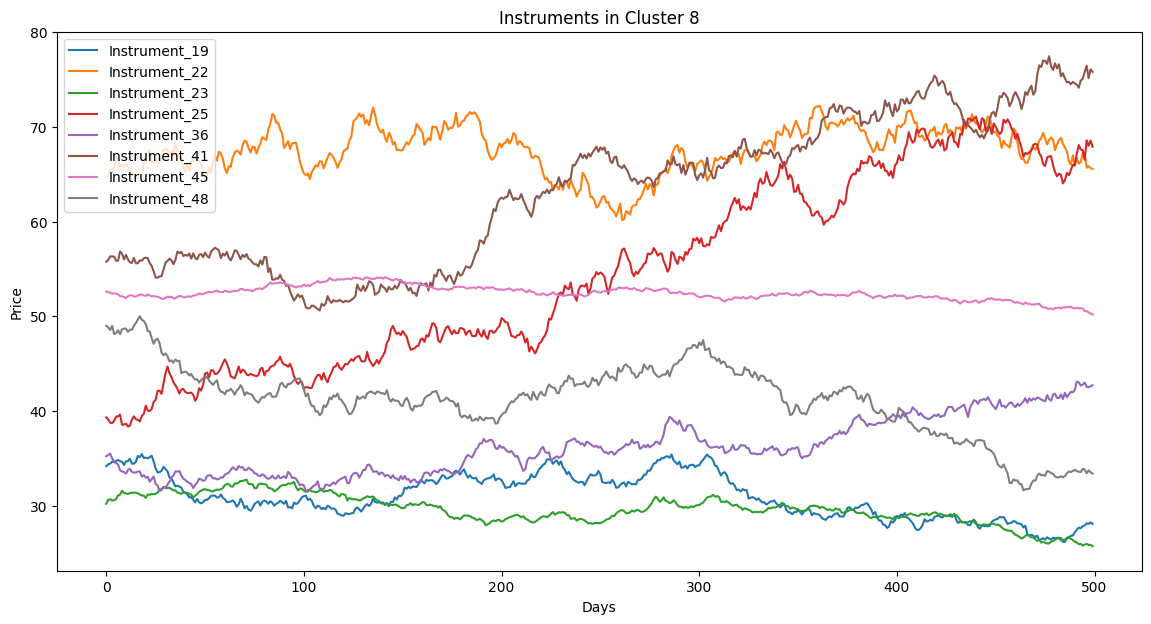

In [8]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
# Load the price data
prices = np.loadtxt('prices.txt')

# Convert to DataFrame for easier analysis
df = pd.DataFrame(prices, columns=[f'Instrument_{i}' for i in range(prices.shape[1])])

# Calculate daily returns
returns = df.pct_change().dropna()

# Compute the correlation matrix
corr_matrix = returns.corr()

# Create a distance matrix from the correlation matrix
distance_matrix = 1 - corr_matrix

# Perform hierarchical clustering
linked = linkage(distance_matrix, method='ward')

# Plot the dendrogram
plt.figure(figsize=(14, 7))
dendrogram(linked, labels=corr_matrix.columns, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Instrument')
plt.ylabel('Distance')
plt.show()

# Form flat clusters from the hierarchical clustering
n_clusters = 10
clusters = fcluster(linked, n_clusters, criterion='maxclust')

# Assign clusters to instruments
instrument_clusters = pd.DataFrame({'Instrument': df.columns, 'Cluster': clusters})

# Plot instruments by clusters
for cluster in np.unique(clusters):
    cluster_instruments = instrument_clusters[instrument_clusters['Cluster'] == cluster]['Instrument']
    plt.figure(figsize=(14, 7))
    for instrument in cluster_instruments:
        plt.plot(df.index, df[instrument], label=instrument)
    plt.title(f'Instruments in Cluster {cluster}')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
